<a href="https://colab.research.google.com/github/Amallh/amallh.github.io/blob/main/image_processing_amal_lahchim_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Extracting and Listing Files from a ZIP Archive**

In [ ]:
import zipfile
import os
zip_file_path = "/content/archive (4).zip"
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall("unzipped_folder4")
extracted_files = os.listdir("unzipped_folder4")
print(extracted_files)

['lung_and_infection_mask', 'infection_mask', 'lung_mask', 'ct_scans', 'metadata.csv']


In [ ]:
!pip install pandas numpy nibabel matplotlib pickle-mixin opencv-python tensorflow



  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 34.0 MB/s eta 0:00:00
  Created wheel for pickle-mixin: filename=pickle_mixin-1.0.2-py3-none-any.whl size=5990 sha256=1b274d3b4811fabb185b1fa91eb1f3ef00840eeedcdbd29ce2e880b695bf05ad
  Stored in directory: /root/.cache/pip/wheels/3e/c6/e9/d1b0a34e1efc6c3ec9c086623972c6de6317faddb2af0a619c
Successfully built pickle-mixin


In [ ]:
import glob
import pandas  as pd
import numpy   as np
import nibabel as nib
import matplotlib.pyplot as plt
import pickle
import cv2
import tensorflow as tf

In [ ]:
# Read and examine metadata
data = pd.read_csv('/content/unzipped_folder4/metadata.csv')
data.sample(5)
data.head(3)

ct_scan  \
0  ../input/covid19-ct-scans/ct_scans/coronacases...   
1  ../input/covid19-ct-scans/ct_scans/coronacases...   
2  ../input/covid19-ct-scans/ct_scans/coronacases...   

                                           lung_mask  \
0  ../input/covid19-ct-scans/lung_mask/coronacase...   
1  ../input/covid19-ct-scans/lung_mask/coronacase...   
2  ../input/covid19-ct-scans/lung_mask/coronacase...   

                                      infection_mask  \
0  ../input/covid19-ct-scans/infection_mask/coron...   
1  ../input/covid19-ct-scans/infection_mask/coron...   
2  ../input/covid19-ct-scans/infection_mask/coron...   

                             lung_and_infection_mask  
0  ../input/covid19-ct-scans/lung_and_infection_m...  
1  ../input/covid19-ct-scans/lung_and_infection_m...  
2  ../input/covid19-ct-scans/lung_and_infection_m...

In [ ]:
def read_nii(filepath):
    '''
    Reads .nii file and returns pixel array
    '''
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array)) #this data needs to rotate 90 degrees
    return(array)

In [ ]:
# Update the file path to match the correct location of the file
filepath = '/content/unzipped_folder4/ct_scans/coronacases_org_001.nii'

# Call the read_nii function
sample_ct = read_nii(filepath)

In [ ]:
print (sample_ct.shape)

(512, 512, 301)


**Histogram of Hounsfield Units (HU) Distribution from CT Image Data**

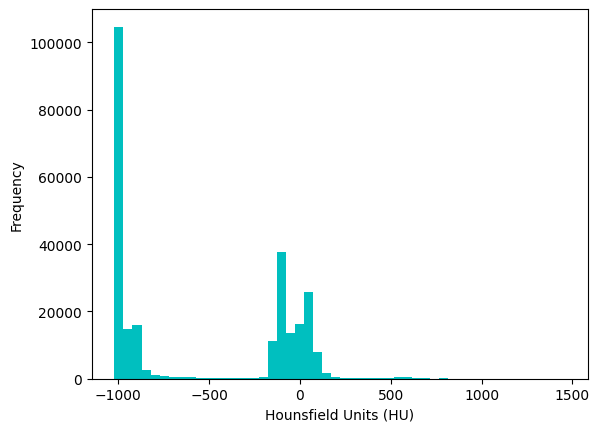

In [ ]:
imgs_to_process = sample_ct[...,1]

plt.hist(imgs_to_process.flatten(), bins=50, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

In [ ]:
import pandas as pd
import os

# Load metadata
metadata = pd.read_csv('/content/unzipped_folder4/metadata.csv')

# Update paths in the metadata
base_path = '/content/unzipped_folder4/'
metadata['ct_scan'] = metadata['ct_scan'].apply(lambda x: os.path.join(base_path, os.path.basename(x)))
metadata['infection_mask'] = metadata['infection_mask'].apply(lambda x: os.path.join(base_path, os.path.basename(x)))
metadata['lung_mask'] = metadata['lung_mask'].apply(lambda x: os.path.join(base_path, os.path.basename(x)))
metadata['lung_and_infection_mask'] = metadata['lung_and_infection_mask'].apply(lambda x: os.path.join(base_path, os.path.basename(x)))

# Verify updated paths
print(metadata.head())


                                             ct_scan  \
0  /content/unzipped_folder4/coronacases_org_001.nii   
1  /content/unzipped_folder4/coronacases_org_002.nii   
2  /content/unzipped_folder4/coronacases_org_003.nii   
3  /content/unzipped_folder4/coronacases_org_004.nii   
4  /content/unzipped_folder4/coronacases_org_005.nii   

                                       lung_mask  \
0  /content/unzipped_folder4/coronacases_001.nii   
1  /content/unzipped_folder4/coronacases_002.nii   
2  /content/unzipped_folder4/coronacases_003.nii   
3  /content/unzipped_folder4/coronacases_004.nii   
4  /content/unzipped_folder4/coronacases_005.nii   

                                  infection_mask  \
0  /content/unzipped_folder4/coronacases_001.nii   
1  /content/unzipped_folder4/coronacases_002.nii   
2  /content/unzipped_folder4/coronacases_003.nii   
3  /content/unzipped_folder4/coronacases_004.nii   
4  /content/unzipped_folder4/coronacases_005.nii   

                         lung_and_inf

**Preprocessing and Visualizing CT Scans and Mask Slices for Medical Imaging**

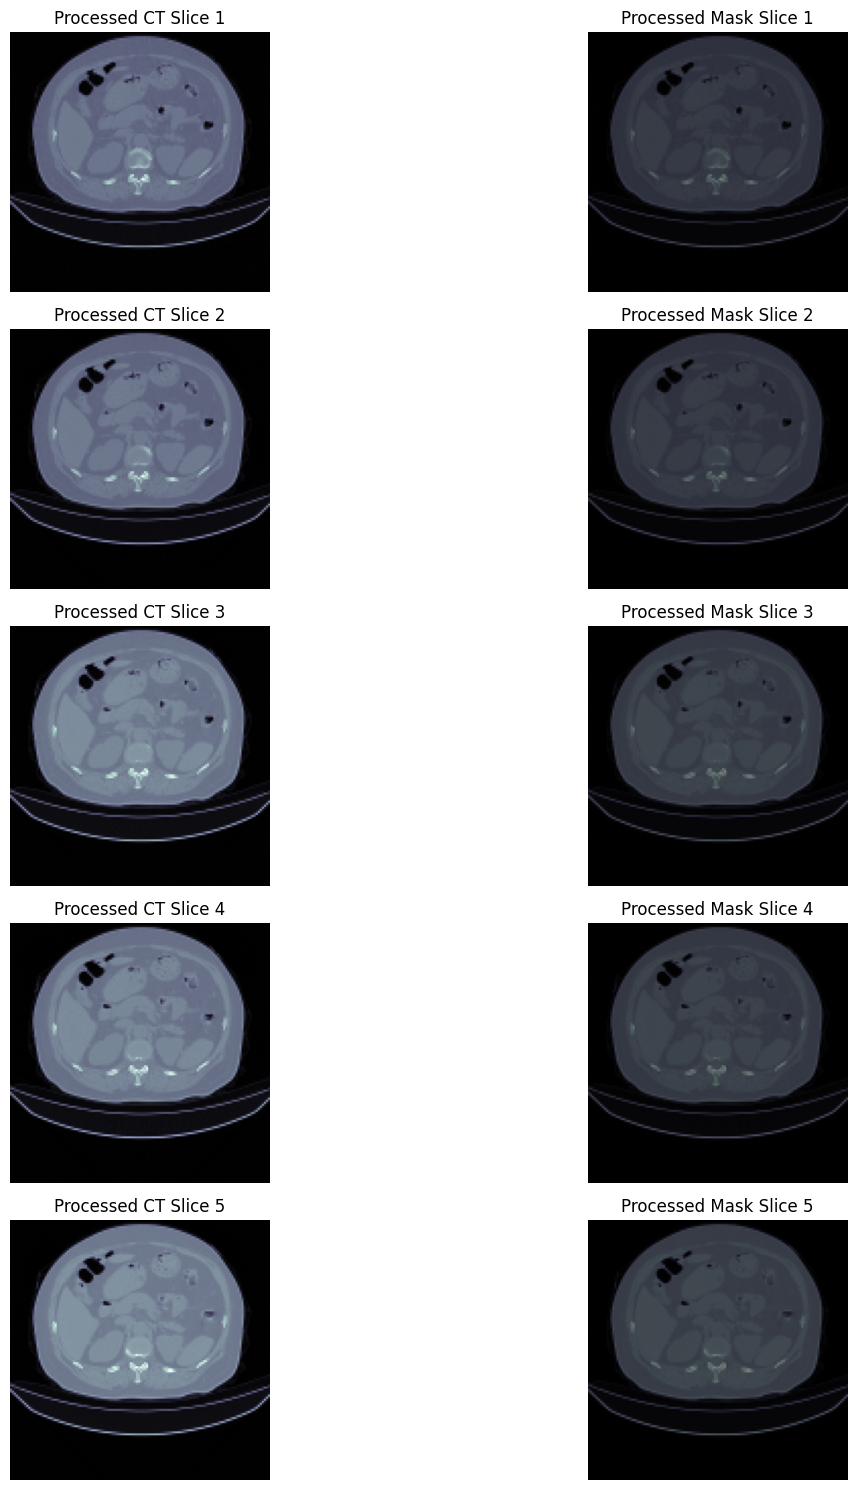

In [ ]:
import os
import cv2
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

# Paths to CT scans and mask directories
ct_scan_dir = '/content/unzipped_folder4/ct_scans'
mask_dir = '/content/unzipped_folder4/infection_mask'

# Target image size for resizing
IMG_SIZE = 128

# my provided `read_nii` function
def read_nii(filepath):
    """
    Reads .nii file and returns pixel array rotated 90 degrees.
    """
    ct_scan = nib.load(filepath)
    array = ct_scan.get_fdata()
    array = np.rot90(np.array(array))  # Rotate 90 degrees counterclockwise
    return array

# Preprocess a single CT and mask slice
def preprocess_slice(ct_slice, mask_slice, img_size):
    """
    Processes a single CT and mask slice:
    - Resizes the images to the target size.
    - Normalizes the CT slice.
    - Binarizes the mask slice.
    - Expands dimensions for model compatibility.
    """
    ct_img = cv2.resize(ct_slice, dsize=(img_size, img_size), interpolation=cv2.INTER_AREA)
    mask_img = cv2.resize(mask_slice, dsize=(img_size, img_size), interpolation=cv2.INTER_AREA)

    # Normalize CT image (scale pixel values to [0, 1])
    ct_img = (ct_img - np.min(ct_img)) / (np.max(ct_img) - np.min(ct_img) + 1e-8)

    # Binarize mask image (ensure values are 0 or 1)
    mask_img = (mask_img > 0).astype(np.float32)

    # Expand dimensions to add a channel
    return ct_img[..., np.newaxis], mask_img[..., np.newaxis]

# Load and preprocess the dataset
def load_and_preprocess_data(ct_dir, mask_dir, img_size):
    """
    Loads CT scans and masks, preprocesses each slice, and returns the dataset as NumPy arrays.
    """
    CT = []
    Mask = []

    # Get sorted lists of CT scan and mask files
    ct_files = sorted([f for f in os.listdir(ct_dir) if f.endswith('.nii')])
    mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith('.nii')])

    # Process each CT scan and corresponding mask
    for ct_file, mask_file in zip(ct_files, mask_files):
        ct_filepath = os.path.join(ct_dir, ct_file)
        mask_filepath = os.path.join(mask_dir, mask_file)

        # Read CT and mask data using my `read_nii` function
        ct = read_nii(ct_filepath)
        mask = read_nii(mask_filepath)

        # Process slices
        for slice_idx in range(ct.shape[2]):
            ct_slice = ct[..., slice_idx]
            mask_slice = mask[..., slice_idx]

            # Preprocess the slice
            ct_img, mask_img = preprocess_slice(ct_slice, mask_slice, img_size)

            # Append the preprocessed slice to the dataset
            CT.append(ct_img)
            Mask.append(mask_img)

    # Convert lists to NumPy arrays
    return np.array(CT, dtype=np.float32), np.array(Mask, dtype=np.float32)

# Load and preprocess the dataset
CT, Mask = load_and_preprocess_data(ct_scan_dir, mask_dir, IMG_SIZE)

# Visualize the processed data
num_images = 5
plt.figure(figsize=(15, num_images * 3))

for i in range(num_images):
    plt.subplot(num_images, 2, 2 * i + 1)
    plt.imshow(CT[i, ..., 0], cmap='bone')
    plt.title(f'Processed CT Slice {i + 1}')
    plt.axis('off')

    plt.subplot(num_images, 2, 2 * i + 2)
    plt.imshow(CT[i, ..., 0], cmap='bone')
    plt.imshow(Mask[i, ..., 0], alpha=0.5, cmap='nipy_spectral')
    plt.title(f'Processed Mask Slice {i + 1}')
    plt.axis('off')

plt.tight_layout()
plt.show()


**Splitting CT Scan and Mask Data into Training, Validation, and Test Sets**

In [ ]:
from sklearn.model_selection import train_test_split

# Step 1: Split the data into training + validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(CT, Mask, test_size=0.2, random_state=42)

# Step 2: Split the training + validation set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# Print the shapes of the splits
print(f"Training Set Shape: {X_train.shape}, {y_train.shape}")
print(f"Validation Set Shape: {X_val.shape}, {y_val.shape}")
print(f"Test Set Shape: {X_test.shape}, {y_test.shape}")



Training Set Shape: (2252, 128, 128, 1), (2252, 128, 128, 1)
Validation Set Shape: (564, 128, 128, 1), (564, 128, 128, 1)
Test Set Shape: (704, 128, 128, 1), (704, 128, 128, 1)


In [ ]:
# Save the entire dataset
np.save('/content/CT_data.npy', CT)
np.save('/content/Mask_data.npy', Mask)

# Save training and validation splits
np.save('/content/X_train.npy', X_train)
np.save('/content/y_train.npy', y_train)
np.save('/content/X_val.npy', X_val)
np.save('/content/y_val.npy', y_val)

print("Datasets saved successfully.")


Datasets saved successfully.


In [ ]:
# Load the data
X_train = np.load('/content/X_train.npy')
y_train = np.load('/content/y_train.npy')
X_val = np.load('/content/X_val.npy')
y_val = np.load('/content/y_val.npy')

print("Datasets loaded successfully.")


Datasets loaded successfully.


In [ ]:
!pip install albumentations


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.1/80.1 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.9/274.9 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 632.7/632.7 kB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.5/304.5 kB 19.4 MB/s eta 0:00:00


**Data Augmentation Pipeline for CT Scan and Mask Images Using Albumentations**

In [ ]:
import albumentations as A

# Define a safe augmentation pipeline
augmentation = A.Compose([
    A.Rotate(limit=(-5, 5), p=0.5),  # Reduce rotation limits to ±5 degrees
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=5, p=0.5),  # Restrict shifts and scale
    A.ElasticTransform(p=0.3, alpha=0.3, sigma=20.0),  # Reduce elastic transform intensity
    A.GaussianBlur(p=0.3, blur_limit=(3, 3)),
    A.RandomBrightnessContrast(p=0.2)
], p=1.0)





# Apply augmentations
def augment_image_and_mask(image, mask, augmentation):
    augmented = augmentation(image=image, mask=mask)
    return augmented['image'], augmented['mask']


In [ ]:
augmented_CT = [] #  List to store augmented CT images
augmented_Mask = [] # List to store augmented masks

# Loop through all the training data and apply augmentation
for i in range(len(X_train)):
    img, msk = augment_image_and_mask(X_train[i, :, :, 0], y_train[i, :, :, 0], augmentation)
    augmented_CT.append(img[..., np.newaxis])  # Add channel dimension to the augmented CT image
    augmented_Mask.append(msk[..., np.newaxis])  # Add channel dimension to the augmented mask

# Convert to NumPy arrays
augmented_CT = np.array(augmented_CT, dtype=np.float32)
augmented_Mask = np.array(augmented_Mask, dtype=np.float32)

# Print the shapes of the augmented CT and mask arrays
print(f"Augmented CT shape: {augmented_CT.shape}")
print(f"Augmented Mask shape: {augmented_Mask.shape}")


Augmented CT shape: (2252, 128, 128, 1)
Augmented Mask shape: (2252, 128, 128, 1)


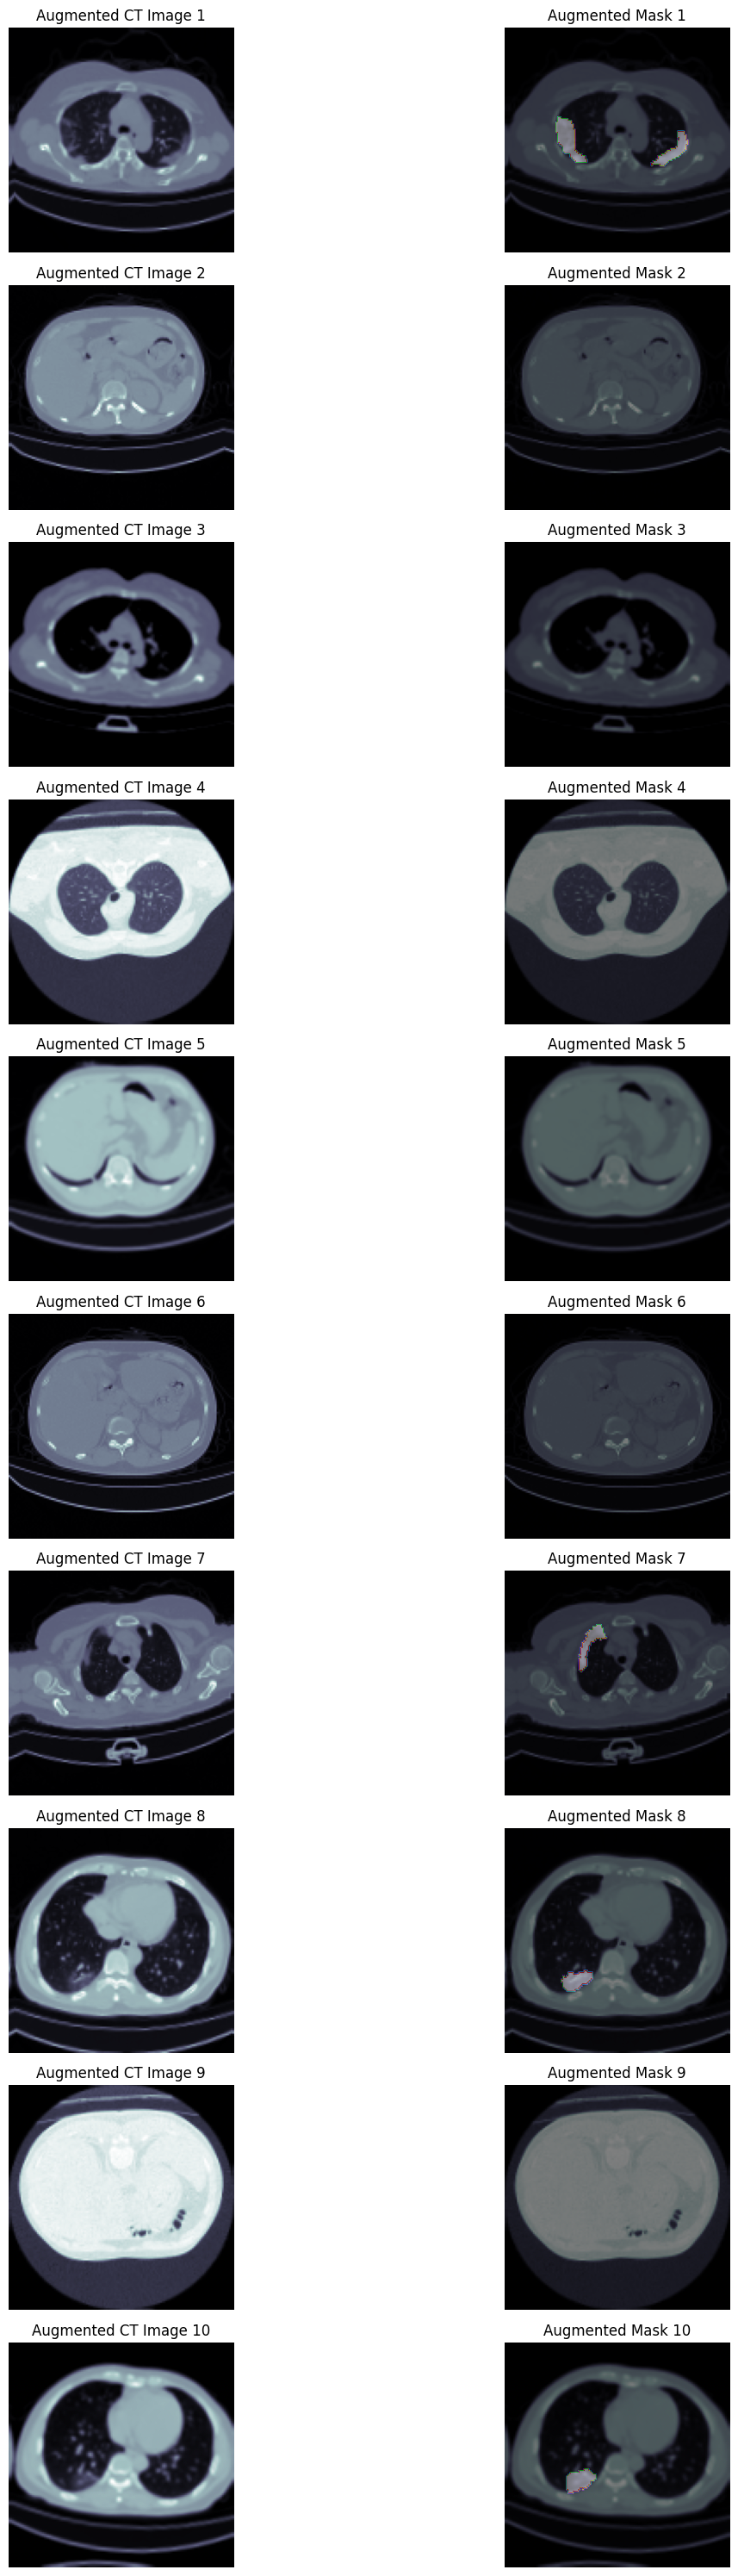

In [ ]:
import matplotlib.pyplot as plt

# Number of images to visualize
num_images = 10  # Adjust as needed

# Visualize augmented images and masks
plt.figure(figsize=(15, num_images * 3))

for i in range(num_images):
    plt.subplot(num_images, 2, 2 * i + 1)
    plt.imshow(augmented_CT[i, ..., 0], cmap='bone')
    plt.title(f'Augmented CT Image {i + 1}')
    plt.axis('off')

    plt.subplot(num_images, 2, 2 * i + 2)
    plt.imshow(augmented_CT[i, ..., 0], cmap='bone')
    plt.imshow(augmented_Mask[i, ..., 0], alpha=0.5, cmap='nipy_spectral')
    plt.title(f'Augmented Mask {i + 1}')
    plt.axis('off')

plt.tight_layout()
plt.show()


**Building an Attention U-Net for Image Segmentation**

In this code, we defined and implemented an Attention U-Net model using TensorFlow and Keras. The Attention U-Net is a variant of the traditional U-Net, incorporating attention mechanisms to focus on relevant features during the encoding and decoding process.

The model consists of several key components:
1. **Convolutional Blocks (conv2d)**: These blocks perform 2D convolutions with batch normalization, activation, and optional dropout to extract features from the input image.
2. **Deconvolutional Blocks (deconv2d)**: These blocks use upsampling followed by convolution to upsample the feature maps in the decoding process.
3. **Attention Blocks (attention_block)**: These blocks use a learned gating mechanism to focus on important features from the encoder, allowing the model to focus on relevant regions when decoding.
4. **U-Net Architecture**: The network is built using an encoder-decoder structure with skip connections. Each decoding layer is combined with an attention block to enhance the feature maps.
5. **ModelCheckpoint**: A Keras callback is used to save the best model during training based on the loss metric.

Finally, the model is compiled with an attention mechanism applied at each decoding step to improve performance on medical image segmentation tasks (or similar tasks where attention-based feature extraction is beneficial).
as you can see in the below code:

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import ModelCheckpoint


class AttentionUNet:
    def __init__(self, img_rows=128, img_cols=128):
        self.img_rows = img_rows
        self.img_cols = img_cols
        self.img_shape = (self.img_rows, self.img_cols, 1)
        self.base_filters = 64

    def build_unet(self):
        def conv2d(layer_input, filters, dropout_rate=0, bn=False):
            x = layers.Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same')(layer_input)
            if bn:
                x = layers.BatchNormalization()(x)
            x = layers.Activation('relu')(x)

            x = layers.Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
            if bn:
                x = layers.BatchNormalization()(x)
            x = layers.Activation('relu')(x)

            if dropout_rate:
                x = layers.Dropout(dropout_rate)(x)

            return x

        def deconv2d(layer_input, filters, bn=False):
            x = layers.UpSampling2D((2, 2))(layer_input)
            x = layers.Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
            if bn:
                x = layers.BatchNormalization()(x)
            x = layers.Activation('relu')(x)

            return x

        def attention_block(F_g, F_l, F_int, bn=False):
            g = layers.Conv2D(F_int, kernel_size=(1, 1), strides=(1, 1), padding='valid')(F_g)
            if bn:
                g = layers.BatchNormalization()(g)

            x = layers.Conv2D(F_int, kernel_size=(1, 1), strides=(1, 1), padding='valid')(F_l)
            if bn:
                x = layers.BatchNormalization()(x)

            psi = layers.Add()([g, x])
            psi = layers.Activation('relu')(psi)

            psi = layers.Conv2D(1, kernel_size=(1, 1), strides=(1, 1), padding='valid')(psi)
            if bn:
                psi = layers.BatchNormalization()(psi)
            psi = layers.Activation('sigmoid')(psi)

            return layers.Multiply()([F_l, psi])

        inputs = layers.Input(shape=self.img_shape)

        conv1 = conv2d(inputs, self.base_filters)
        pool1 = layers.MaxPooling2D((2, 2))(conv1)

        conv2 = conv2d(pool1, self.base_filters * 2, bn=True)
        pool2 = layers.MaxPooling2D((2, 2))(conv2)

        conv3 = conv2d(pool2, self.base_filters * 4, bn=True)
        pool3 = layers.MaxPooling2D((2, 2))(conv3)

        conv4 = conv2d(pool3, self.base_filters * 8, dropout_rate=0.5, bn=True)
        pool4 = layers.MaxPooling2D((2, 2))(conv4)

        conv5 = conv2d(pool4, self.base_filters * 16, dropout_rate=0.5, bn=True)

        up6 = deconv2d(conv5, self.base_filters * 8, bn=True)
        att6 = attention_block(up6, conv4, self.base_filters * 8, bn=True)
        up6 = layers.Concatenate()([up6, att6])
        conv6 = conv2d(up6, self.base_filters * 8)

        up7 = deconv2d(conv6, self.base_filters * 4, bn=True)
        att7 = attention_block(up7, conv3, self.base_filters * 4, bn=True)
        up7 = layers.Concatenate()([up7, att7])
        conv7 = conv2d(up7, self.base_filters * 4)

        up8 = deconv2d(conv7, self.base_filters * 2, bn=True)
        att8 = attention_block(up8, conv2, self.base_filters * 2, bn=True)
        up8 = layers.Concatenate()([up8, att8])
        conv8 = conv2d(up8, self.base_filters * 2)

        up9 = deconv2d(conv8, self.base_filters, bn=True)
        att9 = attention_block(up9, conv1, self.base_filters, bn=True)
        up9 = layers.Concatenate()([up9, att9])
        conv9 = conv2d(up9, self.base_filters)

        outputs = layers.Conv2D(1, kernel_size=(1, 1), strides=(1, 1), activation='sigmoid')(conv9)

        model = Model(inputs=inputs, outputs=outputs)
        return model


# Initialize model and set checkpoint
attention_unet = AttentionUNet(img_rows=128, img_cols=128)
model = attention_unet.build_unet()

checkpoint = ModelCheckpoint(
    filepath="best_model.keras",  # Change to use `.keras` extension
    monitor='loss',
    verbose=1,
    save_best_only=True,
    save_freq='epoch'
)



In this code, we define several building blocks for constructing a neural network model using TensorFlow and Keras, which includes functions for applying Batch Normalization, Convolutional Layers, and Residual Blocks.

1. **batch_activate function**: This function applies Batch Normalization followed by a ReLU activation function to the input tensor. It helps normalize the activations and stabilize training.
2. **convolution_block function**: This function performs a 2D convolution operation followed by an optional activation (and Batch Normalization). It is a basic building block for creating deeper layers in the model.
3. **residual_block function**: This function defines a residual block, which consists of two convolutional layers with a skip connection. The input tensor is added back to the output, enabling better gradient flow during training. Optionally, Batch Normalization and activation can be applied within the residual block.

These blocks are useful for creating deeper models and enhancing training efficiency by helping with gradient flow and feature learning, especially in convolutional neural networks (CNNs) for tasks like image segmentation and classification.
as you can see on the below code:

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import (
    BatchNormalization, Activation, Conv2D, Add
)
from tensorflow.keras.models import Model


# Batch Normalization followed by Activation
def batch_activate(x):
    """
    Apply Batch Normalization followed by ReLU activation.
    """
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x


# Convolutional Block
def convolution_block(x, filters, kernel_size, strides=(1, 1), padding='same', activation=True):
    """
    Apply a convolutional layer with optional activation and batch normalization.
    """
    x = Conv2D(filters, kernel_size, strides=strides, padding=padding)(x)
    if activation:
        x = batch_activate(x)
    return x


# Residual Block
def residual_block(input_tensor, num_filters=16, batch_activate=False):
    """
    Apply a residual block consisting of two convolutional layers
    with a skip connection and optional batch activation.
    """
    x = batch_activate(input_tensor)
    x = convolution_block(x, num_filters, kernel_size=(3, 3))
    x = convolution_block(x, num_filters, kernel_size=(3, 3), activation=False)
    x = Add()([x, input_tensor])
    if batch_activate:
        x = batch_activate(x)
    return x


This code defines various loss functions for segmentation tasks:

1. dice_loss: Calculates the Dice coefficient as a loss to measure the overlap between predicted and true masks.
2. bce_dice_loss: Combines Binary Cross-Entropy (BCE) and Dice loss to improve pixel-level classification and overlap.
3. bce_logdice_loss: Combines BCE with Log Dice loss to emphasize improving Dice score during training.
4. weighted_bce_dice_loss: Combines BCE and Dice loss with weighting to handle class imbalances more effectively.
5. weighted_dice_loss: Computes a weighted Dice loss for focusing on important areas of the segmentation mask.                                                                            **as mentioned below on code:**

In [ ]:
import tensorflow as tf

def dice_loss(y_true, y_pred, smooth=1.0):
    """
    Compute Dice loss.
    """
    y_true_f = tf.reshape(y_true, [-1])  # Flatten y_true
    y_pred_f = tf.reshape(y_pred, [-1])  # Flatten y_pred
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return 1.0 - score

def bce_dice_loss(y_true, y_pred):
    """
    Combined Binary Crossentropy and Dice Loss.
    """
    bce_loss = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return bce_loss + dice

def bce_logdice_loss(y_true, y_pred):
    """
    Binary Crossentropy combined with Log Dice Loss.
    """
    bce_loss = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    log_dice = -tf.math.log(1.0 - dice_loss(y_true, y_pred) + 1e-7)
    return bce_loss + log_dice

def weighted_bce_dice_loss(y_true, y_pred):
    """
    Weighted Binary Crossentropy and Dice Loss.
    """
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    bce_loss = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)

    intersection = tf.reduce_sum(y_true * y_pred)
    dice = 1.0 - (2.0 * intersection + 1.0) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + 1.0)

    return 0.5 * bce_loss + 0.5 * dice

def weighted_dice_loss(y_true, y_pred, weight):
    """
    Weighted Dice Loss.
    """
    smooth = 1.0
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    weight = tf.cast(weight, tf.float32)

    intersection = tf.reduce_sum(weight * y_true * y_pred)
    score = (2.0 * intersection + smooth) / (
        tf.reduce_sum(weight * y_true) + tf.reduce_sum(weight * y_pred) + smooth
    )
    return 1.0 - score


In this code, we define the Dice coefficient function, which is a commonly used metric for evaluating the performance of models in segmentation tasks. The Dice coefficient measures the overlap between the predicted segmentation and the ground truth, with higher values indicating better performance.

1. **dice_coef function**:
    - It takes `y_true` (ground truth tensor) and `y_pred` (predicted tensor) as inputs and calculates the Dice coefficient.
    - It computes the intersection and union of the ground truth and predicted tensors, summing over all axes except the batch dimension.
    - A smoothing factor (`smooth`) is used to prevent division by zero when the intersection or union is zero.
    - The Dice coefficient is returned as the mean across the batch.

2. **Usage**: The Dice coefficient is useful for evaluating segmentation models, particularly in medical imaging, where the goal is to measure how well the model's predicted region overlaps with the true region.
**as mention below on code:**


In [ ]:
from keras.optimizers import Adam

def dice_coef(y_true, y_pred, smooth=1):
    """
    Calculate the Dice coefficient for evaluation of segmentation tasks.
    Args:
        y_true: Ground truth tensor.
        y_pred: Prediction tensor.
        smooth: Smoothing factor to prevent division by zero.

    Returns:
        Dice coefficient.
    """
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    return tf.reduce_mean((2. * intersection + smooth) / (union + smooth), axis=0)

In this code, we define functions to calculate the signed distance map and a surface loss for segmentation tasks, utilizing SciPy's `distance_transform_edt` and TensorFlow.

1. **calc_dist_map function**:
    - This function calculates the signed distance map for a single segmentation mask.
    - It first converts the segmentation mask to a binary (boolean) tensor and then computes both the positive and negative distance transforms using SciPy's `distance_transform_edt`.
    - The final signed distance map is obtained by subtracting the positive distance map from the negative one and is returned as a TensorFlow tensor.

2. **calc_dist_map_batch function**:
    - This function computes the signed distance map for a batch of segmentation masks by calling `calc_dist_map` for each mask in the batch and returning the results as a batch tensor.

3. **surface_loss_keras function**:
    - This function computes the surface loss, which encourages the model to focus on the boundary of segmented objects.
    - It calculates the distance map for the ground truth (`y_true`) and multiplies it element-wise with the predicted segmentation (`y_pred`), then averages the result to obtain the loss. ***as mention below on code: ***



In [ ]:
from scipy.ndimage import distance_transform_edt
import tensorflow as tf

def calc_dist_map(segmentation):
    """
    Compute signed distance map using SciPy's distance_transform_edt.
    """
    segmentation = tf.cast(segmentation, tf.bool).numpy()  # Convert to NumPy for SciPy
    pos_dist = distance_transform_edt(segmentation)
    neg_dist = distance_transform_edt(~segmentation)
    dist_map = neg_dist - pos_dist
    return tf.convert_to_tensor(dist_map, dtype=tf.float32)

def calc_dist_map_batch(y_true):
    """
    Compute signed distance map for a batch using SciPy.
    """
    y_true_numpy = y_true.numpy()  # Convert to NumPy
    dist_maps = [calc_dist_map(seg) for seg in y_true_numpy]
    return tf.convert_to_tensor(dist_maps, dtype=tf.float32)

def surface_loss_keras(y_true, y_pred):
    """
    Surface loss calculation using SciPy's distance_transform_edt.
    """
    y_true_dist_map = calc_dist_map_batch(y_true)
    loss = tf.reduce_mean(y_true_dist_map * tf.cast(y_pred, tf.float32))
    return loss





The first code defines and updates a TensorFlow variable (alpha), which can be used to adjust model parameters. The second code creates a wrapper function that combines weighted BCE Dice loss and surface loss, using alpha to control the balance between the two loss terms during training.                                                                       **as mention below respectively:**

In [ ]:
import tensorflow as tf

# Define and initialize alpha
alpha = tf.Variable(1.0, dtype=tf.float32)

# Function to update alpha
def update_alpha(value):
    """
    Update the alpha variable with a new value.
    """
    alpha.assign(value)

# Example of updating alpha
update_alpha(0.5)
print(f"Updated alpha: {alpha.numpy()}")


Updated alpha: 0.5


In [ ]:
def gl_sl_wrapper(alpha):
    """
    Wrapper combining weighted BCE Dice loss and surface loss.
    """
    def gl_sl(y_true, y_pred):
        return alpha * weighted_bce_dice_loss(y_true, y_pred) + (1 - alpha) * surface_loss_keras(y_true, y_pred)
    return gl_sl



In [ ]:
import tensorflow as tf
tf.config.experimental_run_functions_eagerly(True) # it enables eager execution in TensorFlow, allowing operations to be executed immediately for easier debugging and a more interactive development experience.


Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


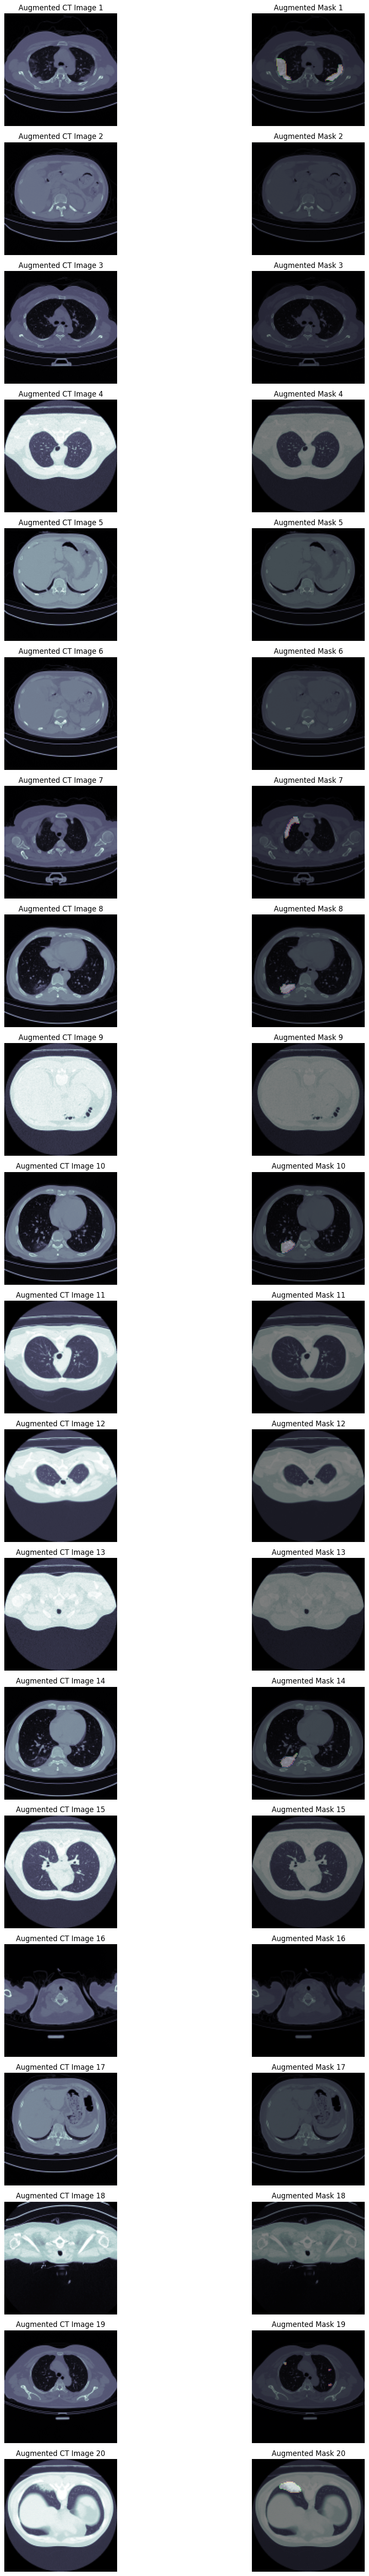

In [ ]:
import matplotlib.pyplot as plt

# Number of images to visualize
num_images = 20

# Set up the plot grid
plt.figure(figsize=(15, num_images * 3))

for i in range(num_images):
    # Augmented CT Image
    plt.subplot(num_images, 2, 2 * i + 1)
    plt.imshow(X_train_augmented[i, ..., 0], cmap='bone')
    plt.title(f'Augmented CT Image {i + 1}')
    plt.axis('off')

    # Augmented Mask
    plt.subplot(num_images, 2, 2 * i + 2)
    plt.imshow(X_train_augmented[i, ..., 0], cmap='bone')
    plt.imshow(y_train_augmented[i, ..., 0], alpha=0.5, cmap='nipy_spectral')
    plt.title(f'Augmented Mask {i + 1}')
    plt.axis('off')

plt.tight_layout()
plt.show()


This code sets up a list of callbacks for model training, including ModelCheckpoint to save the best model weights based on val_dice_coef, ReduceLROnPlateau to reduce the learning rate if the validation Dice coefficient stops improving, and EarlyStopping to halt training if no improvement is seen for 15 epochs. These callbacks are stored in callbacks_list                                                                  **as mentioned below:**

In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

weight_path = "{}_weights.best.weights.h5".format('model')

checkpoint = ModelCheckpoint(
    weight_path,
    monitor='val_dice_coef',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=True
)


reduceLROnPlat = ReduceLROnPlateau(
    monitor='val_dice_coef',
    factor=0.5,
    patience=3,
    verbose=1,
    mode='max',
    min_delta=1e-4,  # Replace epsilon with min_delta
    cooldown=2,
    min_lr=1e-6
)

early = EarlyStopping(
    monitor="val_dice_coef",
    mode="max",
    patience=15
)

callbacks_list = [checkpoint, early, reduceLROnPlat]

This code initializes and compiles a U-Net model using the AttentionUNet class, and the gl_sl_wrapper is used to define the loss function with the dynamic alpha parameter. The model is compiled with the Adam optimizer, a learning rate of 1e-4, and metrics including binary accuracy and Dice coefficient, followed by printing the model summary.                                                                        **as mentioned below:**

In [ ]:
Net = AttentionUNet()  # Correct class name
unet = Net.build_unet()  # Call the method to build the U-Net


unet.compile(
    loss=gl_sl_wrapper(alpha),  # Updated wrapper
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['binary_accuracy', dice_coef]
)


unet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d_35 (Conv2D)          (None, 128, 128, 64)         640       ['input_2[0][0]']             
                                                                                                  
 activation_30 (Activation)  (None, 128, 128, 64)         0         ['conv2d_35[0][0]']           
                                                                                                  
 conv2d_36 (Conv2D)          (None, 128, 128, 64)         36928     ['activation_30[0][0]']       
                                                                                            

***Training U-Net Model with Augmented Data only***





This code trains the U-Net model (unet) using the augmented training data (augmented_CT and augmented_Mask), with validation data (X_val and y_val) for 50 epochs. It includes callbacks from callbacks_list to manage model checkpoints, early stopping, and learning rate adjustments during training.

In [ ]:
history_augmented  = unet.fit(
    augmented_CT, augmented_Mask,
    validation_data=(X_val, y_val),
    epochs=50,
    shuffle=True,verbose=1,
    callbacks=callbacks_list
)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


71/71 [==============================] - ETA: 0s - loss: 1.4086 - binary_accuracy: 0.9883 - dice_coef: 0.0330 
Epoch 1: val_dice_coef improved from -inf to 0.01506, saving model to model_weights.best.weights.h5
71/71 [==============================] - 846s 12s/step - loss: 1.4086 - binary_accuracy: 0.9883 - dice_coef: 0.0330 - val_loss: 2.5060 - val_binary_accuracy: 0.9882 - val_dice_coef: 0.0151 - lr: 1.0000e-04
Epoch 2/50
71/71 [==============================] - ETA: 0s - loss: 0.2589 - binary_accuracy: 0.9897 - dice_coef: 0.1209 
Epoch 2: val_dice_coef did not improve from 0.01506
71/71 [==============================] - 852s 12s/step - loss: 0.2589 - binary_accuracy: 0.9897 - dice_coef: 0.1209 - val_loss: 0.4412 - val_binary_accuracy: 0.9882 - val_dice_coef: 0.0099 - lr: 1.0000e-04
Epoch 3/50
71/71 [==============================] - ETA: 0s - loss: 0.2196 - binary_accuracy: 0.9897 - dice_coef: 0.2315 
Epoch 3: val_dice_coef improved from 0.01506 to 0.09079, saving model to model_we

In [ ]:
unet.load_weights(weight_path)
#unet.save('model.h5')

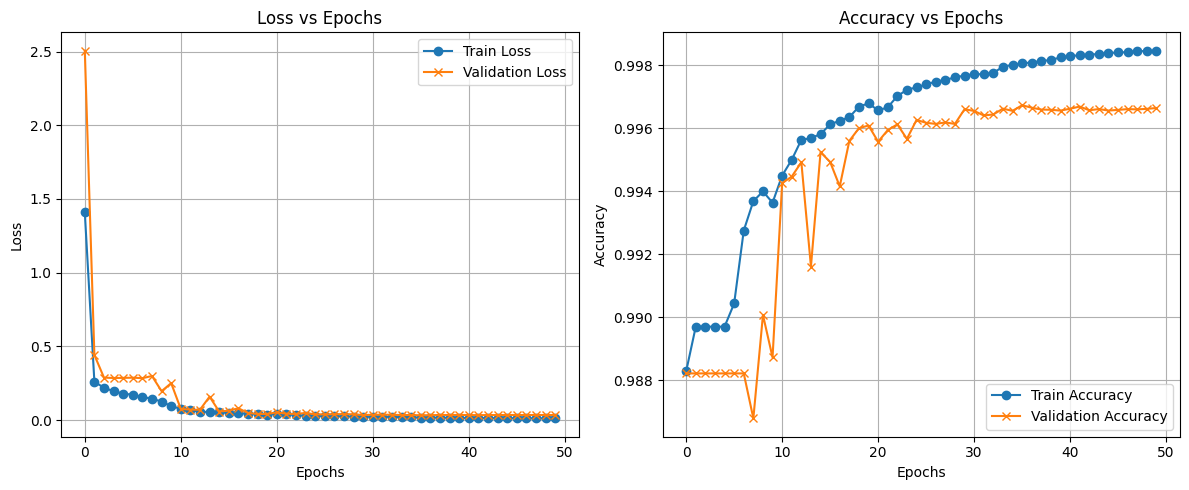

In [ ]:
import matplotlib.pyplot as plt

# Function to plot training history
def plot_training_history(history):
    """
    Plots training and validation loss and accuracy over epochs.

    Parameters:
    history: History object from model.fit() containing metrics.
    """
    # Extract the metrics from the history object
    history_dict = history.history

    # Create the figure
    plt.figure(figsize=(12, 5))

    # Subplot for Loss
    plt.subplot(1, 2, 1)
    plt.plot(history_dict['loss'], label='Train Loss', marker='o')
    plt.plot(history_dict['val_loss'], label='Validation Loss', marker='x')
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)

    # Subplot for Accuracy
    if 'binary_accuracy' in history_dict:  # Check for binary accuracy
        plt.subplot(1, 2, 2)
        plt.plot(history_dict['binary_accuracy'], label='Train Accuracy', marker='o')
        plt.plot(history_dict['val_binary_accuracy'], label='Validation Accuracy', marker='x')
        plt.title('Accuracy vs Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend(loc='lower right')
        plt.grid(True)

    plt.tight_layout()
    plt.show()

# Use the function to plot
plot_training_history(history_augmented)


In [ ]:
# Evaluate on the test set
results = unet.evaluate(X_test, y_test)

# Unpack results
test_loss = results[0]  # Loss is always the first value
test_binary_accuracy = results[1]  # The first metric (binary_accuracy)
test_dice_coef = results[2]  # The second metric (dice_coef)

print(f"Test Loss: {test_loss}")
print(f"Test Binary Accuracy: {test_binary_accuracy}")
print(f"Test Dice Coefficient: {test_dice_coef}")



/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


22/22 [==============================] - 43s 2s/step - loss: 0.0314 - binary_accuracy: 0.9972 - dice_coef: 0.8658
Test Loss: 0.031407322734594345
Test Binary Accuracy: 0.9972249865531921
Test Dice Coefficient: 0.8658058047294617


22/22 [==============================] - 37s 2s/step


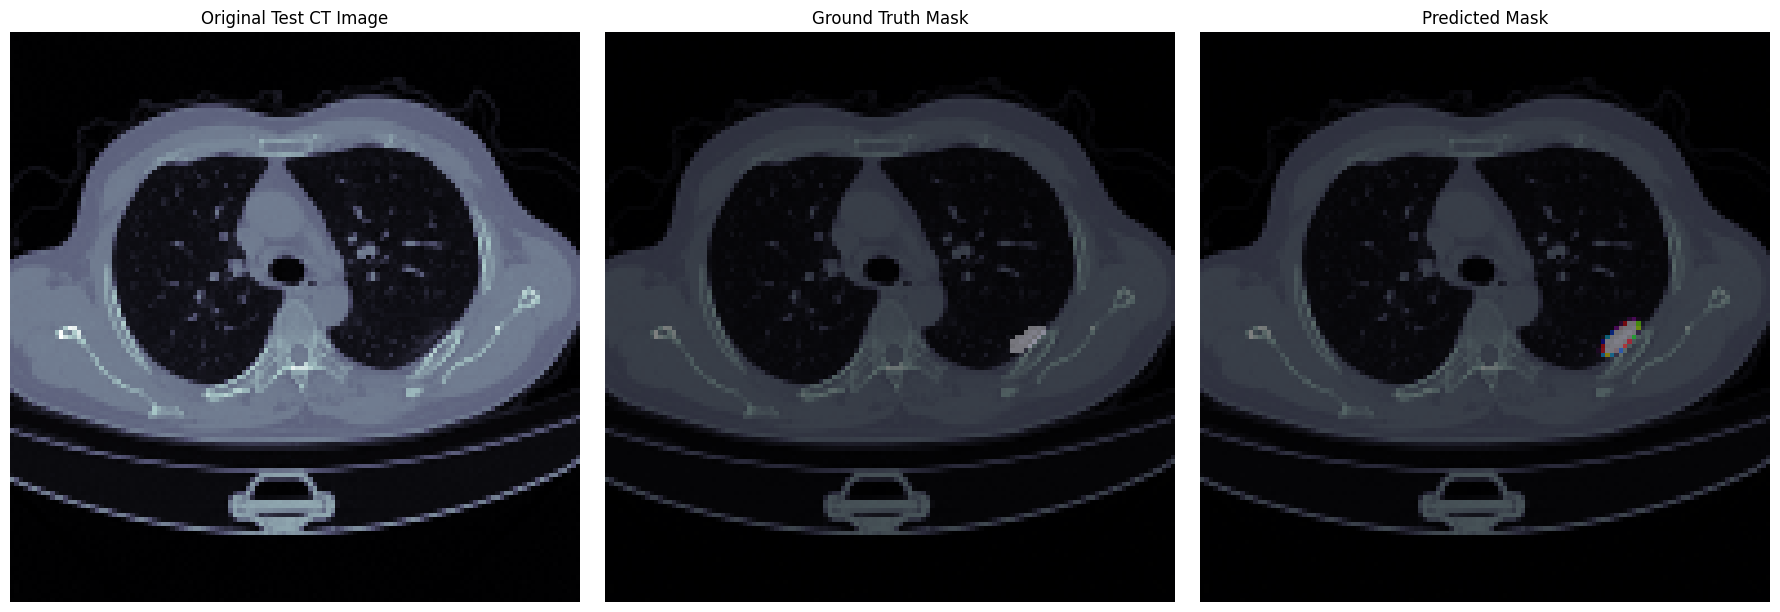

In [ ]:
# Generate predictions for the test set
predicted_masks = unet.predict(X_test)

import matplotlib.pyplot as plt

# Index of the test sample to visualize
i = 20  # Change this index to visualize different samples

plt.figure(figsize=(18, 6))

# Original CT Image
plt.subplot(1, 3, 1)
plt.imshow(X_test[i, ..., 0], cmap='bone')
plt.title('Original Test CT Image')
plt.axis('off')

# Ground Truth Mask
plt.subplot(1, 3, 2)
plt.imshow(X_test[i, ..., 0], cmap='bone')
plt.imshow(y_test[i, ..., 0], alpha=0.5, cmap='nipy_spectral')
plt.title('Ground Truth Mask')
plt.axis('off')

# Predicted Mask
plt.subplot(1, 3, 3)
plt.imshow(X_test[i, ..., 0], cmap='bone')
plt.imshow(predicted_masks[i, ..., 0], alpha=0.5, cmap='nipy_spectral')
plt.title('Predicted Mask')
plt.axis('off')

plt.tight_layout()
plt.show()



**post processing**

22/22 [==============================] - 36s 2s/step


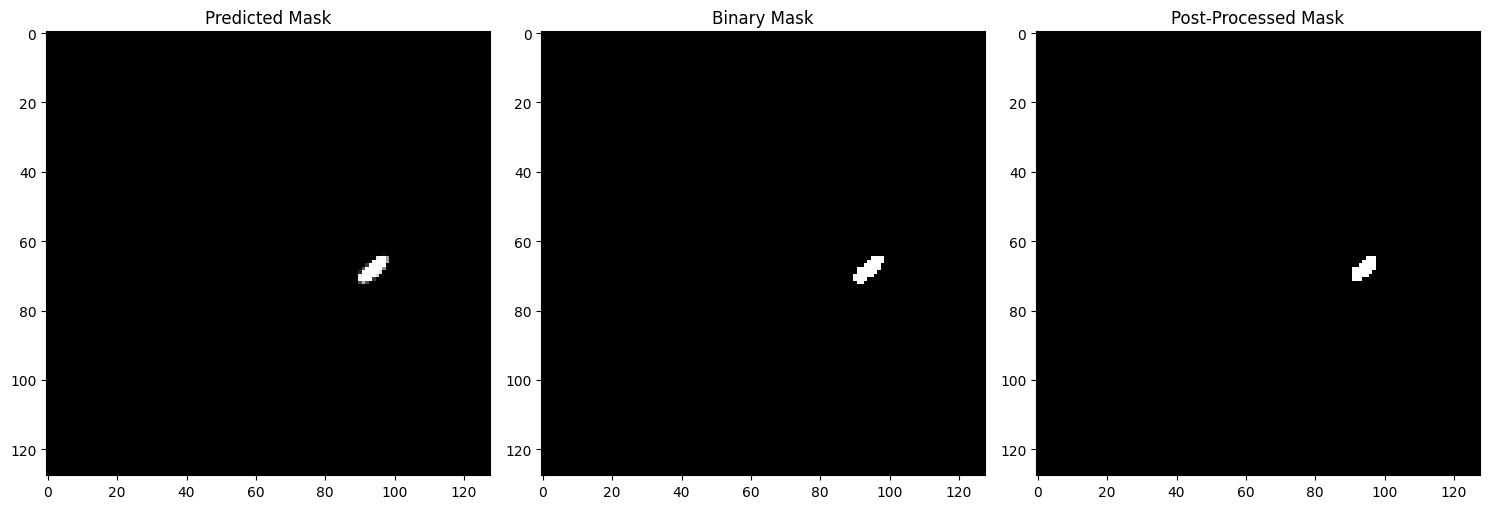

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def post_process_pipeline(mask, target_size=(128, 128), threshold=0.3, min_size=10):
    """
    Post-process a predicted mask.

    Parameters:
    mask (numpy array): Predicted mask.
    target_size (tuple): Desired output size (height, width).
    threshold (float): Threshold for binarization.
    min_size (int): Minimum size for connected components to retain.

    Returns:
    numpy array: Post-processed binary mask.
    """
    # Step 1: Thresholding
    mask = (mask > threshold).astype(np.uint8)

    # Step 2: Morphological Operations
    kernel = np.ones((3, 3), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)  # Remove small noise
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)  # Fill small holes

    # Step 3: Remove Small Objects
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)
    sizes = stats[1:, -1]  # Exclude background size
    new_mask = np.zeros_like(mask)

    for i in range(1, num_labels):
        if sizes[i - 1] >= min_size:
            new_mask[labels == i] = 1

    # Step 4: Resize to Original Dimensions
    mask = cv2.resize(new_mask, target_size, interpolation=cv2.INTER_NEAREST)

    return mask

# Generate predictions for the test set
predicted_masks = unet.predict(X_test)

# Post-process all predicted masks
target_size = (X_test.shape[1], X_test.shape[2])  # Assuming the original input dimensions
final_masks = np.array([post_process_pipeline(mask, target_size=target_size, threshold=0.3, min_size=10) for mask in predicted_masks])

# Visualization
idx = 20  # Choose a sample index to visualize
plt.figure(figsize=(15, 5))

# Predicted mask
plt.subplot(1, 3, 1)
plt.title("Predicted Mask")
plt.imshow(predicted_masks[idx].squeeze(), cmap='gray')

# Binary mask (after thresholding)
plt.subplot(1, 3, 2)
plt.title("Binary Mask")
plt.imshow((predicted_masks[idx] > 0.3).astype(np.uint8).squeeze(), cmap='gray')

# Final post-processed mask
plt.subplot(1, 3, 3)
plt.title("Post-Processed Mask")
plt.imshow(final_masks[idx].squeeze(), cmap='gray')

plt.tight_layout()
plt.show()


**Evaluating Model Performance: ROC Curve, Confusion Matrix, and Classification Metrics for Segmentation**

22/22 [==============================] - 37s 2s/step


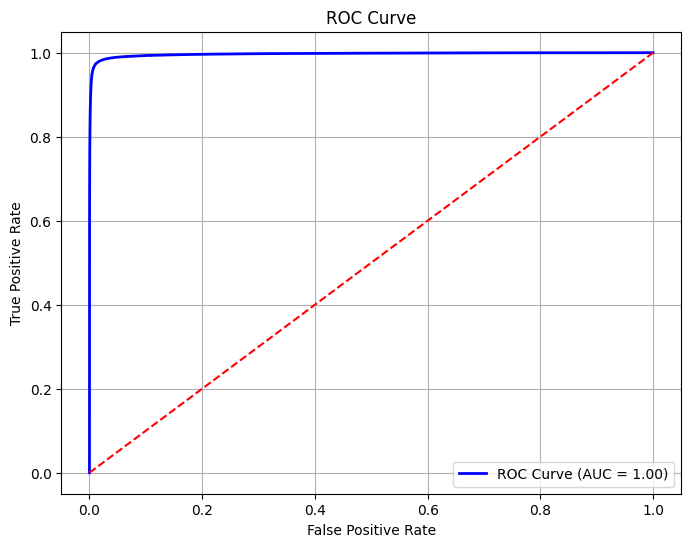

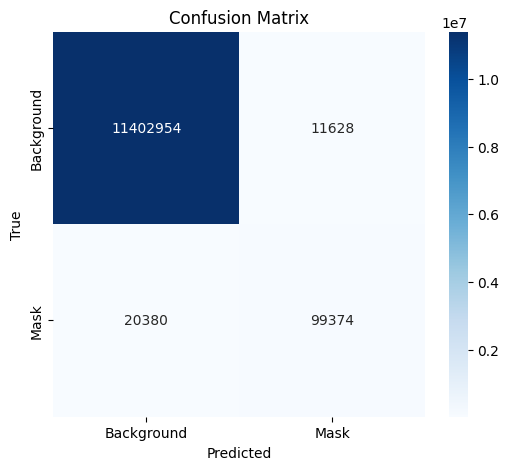

Accuracy: 0.9972
Classification Report:
              precision    recall  f1-score   support

  Background       1.00      1.00      1.00  11414582
        Mask       0.90      0.83      0.86    119754

    accuracy                           1.00  11534336
   macro avg       0.95      0.91      0.93  11534336
weighted avg       1.00      1.00      1.00  11534336



In [ ]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Generate predictions for the test set
predicted = unet.predict(X_test)

# Flatten ground truth and predicted masks
y_true = y_test.flatten()  # Ground truth (original masks)
y_pred = predicted.flatten()  # Predicted masks

# Binarize predictions and ground truth
threshold = 0.5
y_pred_bin = (y_pred > threshold).astype(int)  # Binarized predictions
y_true_bin = (y_true > threshold).astype(int)  # Binarized ground truth

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_true_bin, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_bin, y_pred_bin)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Background', 'Mask'], yticklabels=['Background', 'Mask'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Accuracy Score
accuracy = accuracy_score(y_true_bin, y_pred_bin)
print(f"Accuracy: {accuracy:.4f}")

# Classification Report
class_report = classification_report(y_true_bin, y_pred_bin, target_names=['Background', 'Mask'])
print("Classification Report:")
print(class_report)



**Calculating and Visualizing Intersection over Union (IoU)**

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 188ms/step
Mean IoU: 0.8193


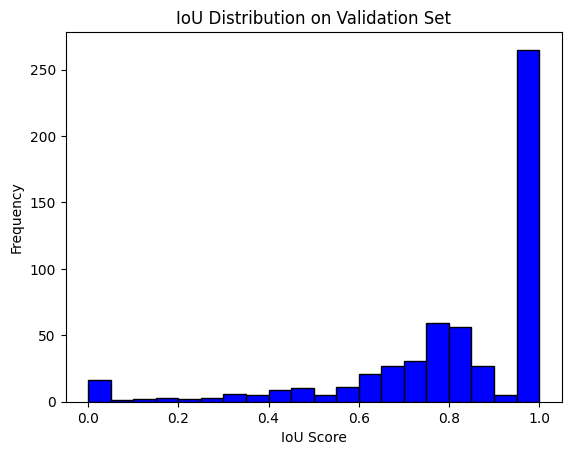

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_iou(y_true, y_pred, threshold=0.5):
    """
    Calculate Intersection over Union (IoU) for binary masks.

    Parameters:
    y_true (numpy array): Ground truth binary mask.
    y_pred (numpy array): Predicted binary mask.
    threshold (float): Threshold to binarize predictions (default=0.5).

    Returns:
    float: IoU score.
    """
    # Binarize predictions using the threshold
    y_pred_binarized = (y_pred > threshold).astype(np.float32)

    # Calculate Intersection and Union
    intersection = np.sum(np.logical_and(y_true, y_pred_binarized))
    union = np.sum(np.logical_or(y_true, y_pred_binarized))

    # Avoid division by zero
    if union == 0:
        return 1.0 if intersection == 0 else 0.0

    return intersection / union

# Initialize variables
threshold = 0.5
iou_scores = []

# Loop through validation data
for i in range(len(X_val)):
    # Get ground truth and prediction
    y_true = y_val[i]  # Ground truth mask
    y_pred = history_augmented.model.predict(np.expand_dims(X_val[i], axis=0))[0]  # Predicted mask

    # Calculate IoU
    iou = calculate_iou(y_true, y_pred, threshold=threshold)
    iou_scores.append(iou)

# Calculate mean IoU
mean_iou = np.mean(iou_scores)
print(f"Mean IoU: {mean_iou:.4f}")

# Plot IoU Distribution
plt.hist(iou_scores, bins=20, color='blue', edgecolor='black')
plt.title('IoU Distribution on Validation Set')
plt.xlabel('IoU Score')
plt.ylabel('Frequency')
plt.show()


1/1 [==============================] - 0s 187ms/step
Mean IoU on Test Data: 0.8316


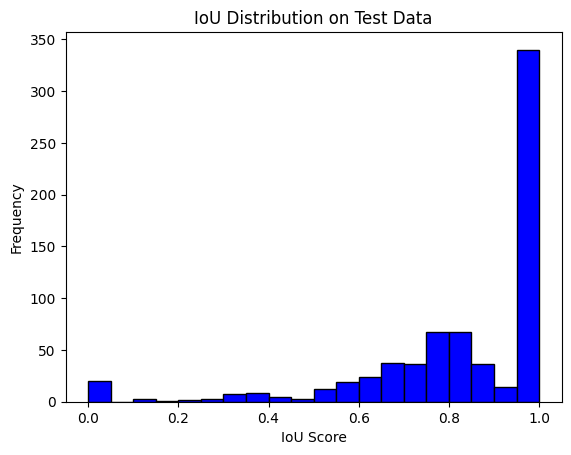

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_iou(y_true, y_pred, threshold=0.5):
    """
    Calculate Intersection over Union (IoU) for binary masks.

    Parameters:
    y_true (numpy array): Ground truth binary mask.
    y_pred (numpy array): Predicted binary mask.
    threshold (float): Threshold to binarize predictions (default=0.5).

    Returns:
    float: IoU score.
    """
    # Binarize predictions using the threshold
    y_pred_binarized = (y_pred > threshold).astype(np.float32)

    # Calculate Intersection and Union
    intersection = np.sum(np.logical_and(y_true, y_pred_binarized))
    union = np.sum(np.logical_or(y_true, y_pred_binarized))

    # Avoid division by zero
    if union == 0:
        return 1.0 if intersection == 0 else 0.0

    return intersection / union

# Initialize variables
threshold = 0.5
iou_scores = []

# Loop through test data
for i in range(len(X_test)):
    # Get ground truth and prediction
    y_true = y_test[i]  # Ground truth mask
    y_pred = history_augmented.model.predict(np.expand_dims(X_test[i], axis=0))[0]  # Predicted mask

    # Calculate IoU
    iou = calculate_iou(y_true, y_pred, threshold=threshold)
    iou_scores.append(iou)

# Calculate mean IoU
mean_iou = np.mean(iou_scores)
print(f"Mean IoU on Test Data: {mean_iou:.4f}")

# Plot IoU Distribution
plt.hist(iou_scores, bins=20, color='blue', edgecolor='black')
plt.title('IoU Distribution on Test Data')
plt.xlabel('IoU Score')
plt.ylabel('Frequency')
plt.show()


**Calculating Hausdorff Distance for Binary Masks**

In [ ]:
from scipy.spatial.distance import directed_hausdorff

def hausdorff_distance(y_true, y_pred, threshold=0.5):
    """
    Compute the Hausdorff distance between the ground truth and predicted masks.

    Parameters:
    y_true (numpy array): Ground truth binary mask.
    y_pred (numpy array): Predicted binary mask.
    threshold (float): Threshold to binarize predictions.

    Returns:
    float: Hausdorff distance.
    """
    # Binarize the prediction
    y_pred_bin = (y_pred > threshold).astype(np.uint8)

    # Extract boundary points of both masks
    true_points = np.argwhere(y_true)
    pred_points = np.argwhere(y_pred_bin)

    # Compute the directed Hausdorff distance
    forward = directed_hausdorff(true_points, pred_points)[0]
    backward = directed_hausdorff(pred_points, true_points)[0]

    return max(forward, backward)

# Example usage:
hd = hausdorff_distance(y_true, y_pred)
print(f"Hausdorff Distance: {hd:.4f}")


Hausdorff Distance: 9.8995


**Calculating Average Symmetric Surface Distance (ASSD) for Binary Mask Segmentation**

In [ ]:
from scipy.spatial.distance import cdist

def assd(y_true, y_pred, threshold=0.5):
    """
    Compute the Average Symmetric Surface Distance (ASSD).

    Parameters:
    y_true (numpy array): Ground truth binary mask.
    y_pred (numpy array): Predicted binary mask.
    threshold (float): Threshold to binarize predictions.

    Returns:
    float: ASSD score.
    """
    # Binarize the prediction
    y_pred_bin = (y_pred > threshold).astype(np.uint8)

    # Extract boundary points of both masks
    true_points = np.argwhere(y_true)
    pred_points = np.argwhere(y_pred_bin)

    # Compute pairwise distances
    distances_true_to_pred = cdist(true_points, pred_points).min(axis=1)
    distances_pred_to_true = cdist(pred_points, true_points).min(axis=1)

    # Average the distances in both directions
    return (np.mean(distances_true_to_pred) + np.mean(distances_pred_to_true)) / 2

# Example usage:
assd_score = assd(y_true, y_pred)
print(f"ASSD: {assd_score:.4f}")


ASSD: 0.3888


***here , want to test the data again  without any augmentation***

In [ ]:
history_normal  = unet.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    shuffle=True,verbose=1,
    callbacks=callbacks_list
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


71/71 [==============================] - ETA: 0s - loss: 2.8592 - binary_accuracy: 0.9694 - dice_coef: 0.0230 
Epoch 1: val_dice_coef improved from -inf to 0.01023, saving model to model_weights.best.weights.h5
71/71 [==============================] - 806s 11s/step - loss: 2.8592 - binary_accuracy: 0.9694 - dice_coef: 0.0230 - val_loss: 1.4883 - val_binary_accuracy: 0.9882 - val_dice_coef: 0.0102 - lr: 1.0000e-04
Epoch 2/50
71/71 [==============================] - ETA: 0s - loss: 0.2478 - binary_accuracy: 0.9897 - dice_coef: 0.1134 
Epoch 2: val_dice_coef improved from 0.01023 to 0.02632, saving model to model_weights.best.weights.h5
71/71 [==============================] - 820s 12s/step - loss: 0.2478 - binary_accuracy: 0.9897 - dice_coef: 0.1134 - val_loss: 0.3175 - val_binary_accuracy: 0.9882 - val_dice_coef: 0.0263 - lr: 1.0000e-04
Epoch 3/50
71/71 [==============================] - ETA: 0s - loss: 0.2059 - binary_accuracy: 0.9897 - dice_coef: 0.2247 
Epoch 3: val_dice_coef improve

In [ ]:
unet.load_weights(weight_path)
#unet.save('model.h5')

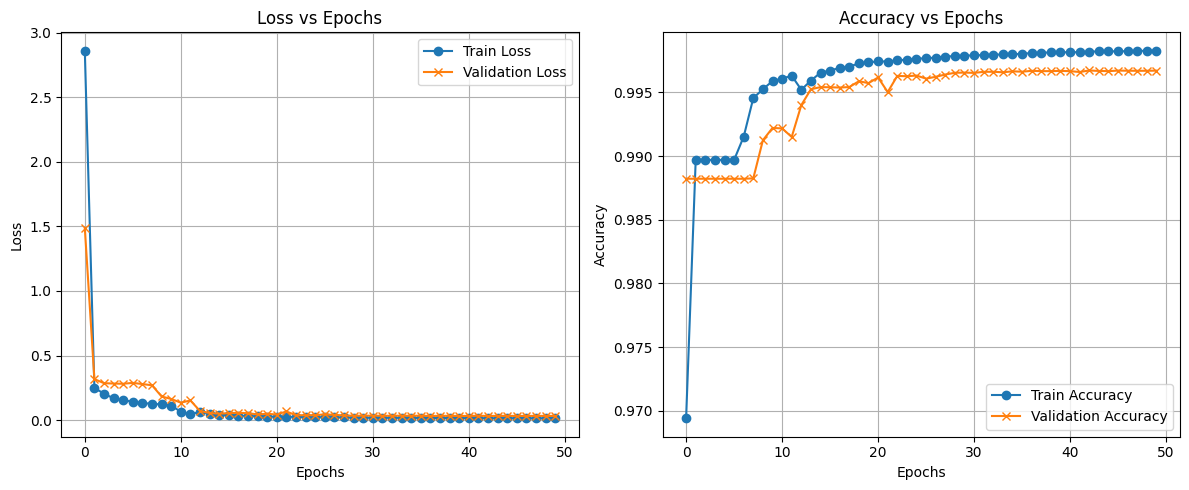

In [ ]:
import matplotlib.pyplot as plt

# Function to plot training history
def plot_training_history(history):
    """
    Plots training and validation loss and accuracy over epochs.

    Parameters:
    history: History object from model.fit() containing metrics.
    """
    # Extract the metrics from the history object
    history_dict = history.history

    # Create the figure
    plt.figure(figsize=(12, 5))

    # Subplot for Loss
    plt.subplot(1, 2, 1)
    plt.plot(history_dict['loss'], label='Train Loss', marker='o')
    plt.plot(history_dict['val_loss'], label='Validation Loss', marker='x')
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)

    # Subplot for Accuracy
    if 'binary_accuracy' in history_dict:  # Check for binary accuracy
        plt.subplot(1, 2, 2)
        plt.plot(history_dict['binary_accuracy'], label='Train Accuracy', marker='o')
        plt.plot(history_dict['val_binary_accuracy'], label='Validation Accuracy', marker='x')
        plt.title('Accuracy vs Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend(loc='lower right')
        plt.grid(True)

    plt.tight_layout()
    plt.show()

# Use the function to plot
plot_training_history(history_normal)


In [ ]:
# Evaluate on the test set
results = unet.evaluate(X_test, y_test)

# Unpack results
test_loss = results[0]  # Loss is always the first value
test_binary_accuracy = results[1]  # The first metric (binary_accuracy)
test_dice_coef = results[2]  # The second metric (dice_coef)

print(f"Test Loss: {test_loss}")
print(f"Test Binary Accuracy: {test_binary_accuracy}")
print(f"Test Dice Coefficient: {test_dice_coef}")

22/22 [==============================] - 40s 2s/step - loss: 0.0331 - binary_accuracy: 0.9972 - dice_coef: 0.8502
Test Loss: 0.033088769763708115
Test Binary Accuracy: 0.997184157371521
Test Dice Coefficient: 0.8502085208892822


In [ ]:
from scipy.spatial.distance import directed_hausdorff

def hausdorff_distance(y_true, y_pred, threshold=0.5):
    """
    Compute the Hausdorff distance between the ground truth and predicted masks.

    Parameters:
    y_true (numpy array): Ground truth binary mask.
    y_pred (numpy array): Predicted binary mask.
    threshold (float): Threshold to binarize predictions.

    Returns:
    float: Hausdorff distance.
    """
    # Binarize the prediction
    y_pred_bin = (y_pred > threshold).astype(np.uint8)

    # Extract boundary points of both masks
    true_points = np.argwhere(y_true)
    pred_points = np.argwhere(y_pred_bin)

    # Compute the directed Hausdorff distance
    forward = directed_hausdorff(true_points, pred_points)[0]
    backward = directed_hausdorff(pred_points, true_points)[0]

    return max(forward, backward)

# Example usage:
hd = hausdorff_distance(y_true, y_pred)
print(f"Hausdorff Distance: {hd:.4f}")

Hausdorff Distance: 8.4853


In [ ]:
from scipy.spatial.distance import cdist

def assd(y_true, y_pred, threshold=0.5):
    """
    Compute the Average Symmetric Surface Distance (ASSD).

    Parameters:
    y_true (numpy array): Ground truth binary mask.
    y_pred (numpy array): Predicted binary mask.
    threshold (float): Threshold to binarize predictions.

    Returns:
    float: ASSD score.
    """
    # Binarize the prediction
    y_pred_bin = (y_pred > threshold).astype(np.uint8)

    # Extract boundary points of both masks
    true_points = np.argwhere(y_true)
    pred_points = np.argwhere(y_pred_bin)

    # Compute pairwise distances
    distances_true_to_pred = cdist(true_points, pred_points).min(axis=1)
    distances_pred_to_true = cdist(pred_points, true_points).min(axis=1)

    # Average the distances in both directions
    return (np.mean(distances_true_to_pred) + np.mean(distances_pred_to_true)) / 2

# Example usage:
assd_score = assd(y_true, y_pred)
print(f"ASSD: {assd_score:.4f}")


ASSD: 0.3907


In [ ]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Prediksi model
predicted = unet.predict(X_test)

# Definisi y_true dan y_pred
y_true = y_test.flatten()  # Ground truth (original masks)
y_pred = predicted.flatten()

# Binarisasi prediksi dan ground truth
threshold = 0.5
y_pred_bin = (y_pred > threshold).astype(int)  # Binarized predictions
#Binarize y_true as well to make it compatible with roc_curve
y_true_bin = (y_true > threshold).astype(int)  # Binarized ground truth

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


22/22 [==============================] - 35s 2s/step


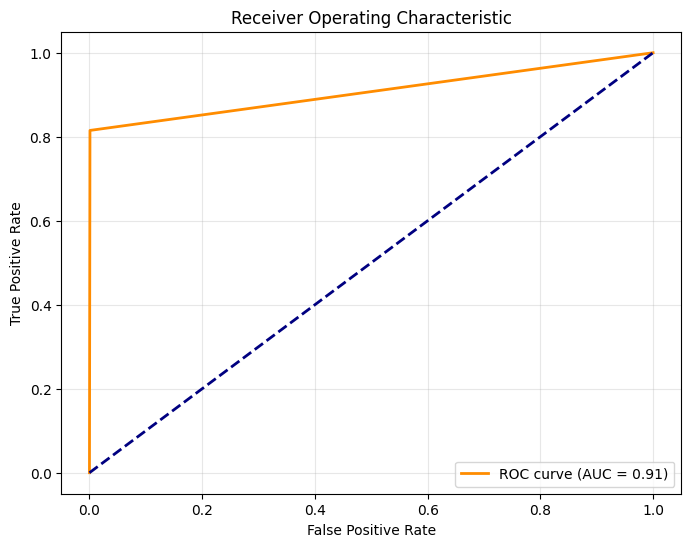

In [ ]:
fpr, tpr, thresholds = roc_curve(y_true_bin, y_pred_bin)  # Gunakan nilai yang sudah dibinarisasi
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

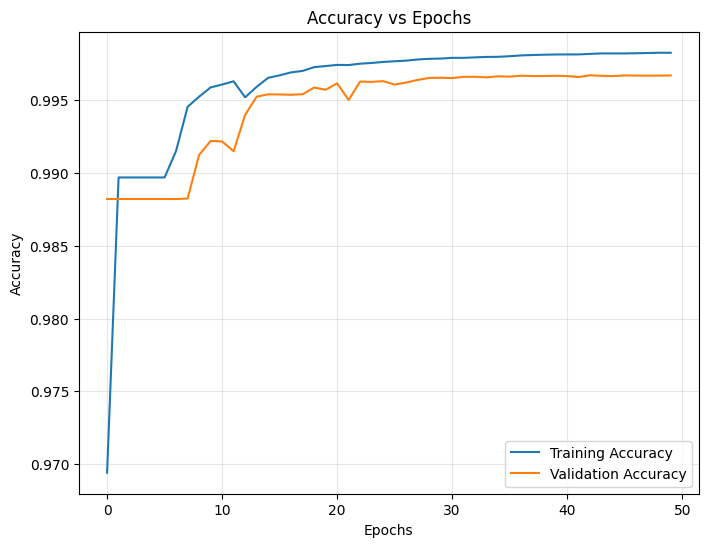

In [ ]:

plt.figure(figsize=(8, 6))
plt.plot(history_normal.history['binary_accuracy'], label='Training Accuracy')
plt.plot(history_normal.history['val_binary_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

In [ ]:
def intersection_over_union(y_true, y_pred):
    smooth = 1e-6  # To avoid division by zero
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

# Contoh penggunaan pada batch
iou_score = intersection_over_union(y_true, y_pred)
print(f"Intersection over Union: {iou_score}")

Intersection over Union: 0.7445449843509355
